## **문제**

한국어로 된 코퍼스를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전저치래서 RNN 모델을 분류기로 사용했을 것이다. 만약 이 문제에서 tokenizer를 sentencepiece로 바꿔 다시 풀어본다면 성능이 좋아질지 비교해보자.

1) 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기  
2) 학습된 모델로 sp_tokenize() 메소드 구현하기   
3) 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기   
4) KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기   
5) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## **1. 데이터 확인 및 전처리**

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [2]:
train_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_test.txt')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
# 중복 및 결측치 확인 및 제거하기

sentences = train_data['document']

min_len = 999
max_len = 0
sum_len = 0

for sen in sentences:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

TypeError: object of type 'float' has no len()

In [7]:
float_elements = []
for index, element in enumerate(sentences):
    if isinstance(element, float):
        float_elements.append((index, element))

float_elements

[(25857, nan), (55737, nan), (110014, nan), (126782, nan), (140721, nan)]

In [8]:
# nan값들 다 지우기

import math

cleaned_sentence = [element for element in sentences if not (isinstance(element, float) and math.isnan(element))]
len(cleaned_sentence)  #150000 -> 14995로 변한 것 확인

149995

In [9]:
min_len = 999
max_len = 0
sum_len = 0

for sen in cleaned_sentence:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_sentence))

sentence_length = np.zeros((max_len), dtype = int)


문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


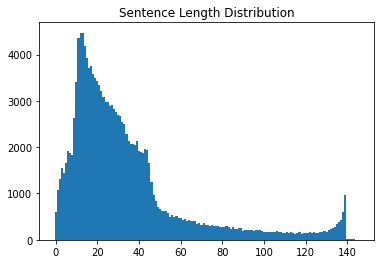

In [10]:
for sen in cleaned_sentence:
    sentence_length[len(sen)-1] +=1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [12]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 20: return

def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 20: return

check_sentence_with_length(cleaned_sentence, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳


In [13]:
check_sentence_with_length(cleaned_sentence, 146)

"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


In [14]:
## 해야할 것: 정규화, 중복처리

cleaned_corpus = list(set(cleaned_sentence))

In [15]:
len(cleaned_corpus) #149995 => 146182

146182

In [21]:
import re

def normalize_korean(text):
    text = re.sub(r'[^가-힣0-9a-zA-Z\s]', '', text)  # 한글, 숫자, 영문자, 공백만 남김
    text = re.sub(r'\s+', ' ', text).strip()  # 여러 개의 공백을 하나로
    
    return text

def normalize_corpus(corpus):
    return [
        normalize_korean(text) 
        for text in corpus 
        if isinstance(text, str) and not (isinstance(text, float) and math.isnan(text))
    ]

normalized_text = normalize_corpus(cleaned_corpus)

In [22]:
normalized_text

['경찰에 신고를 해 제발',
 '아포칼립토짝퉁끝에 숲에서 호랑이나오는거아포칼립토 퓨마 이거까지 따라할줄이야완전감독 넘했다나도만들겠다이렇게',
 '이 영화 보고 사랑이라는 명목하에 불륜 바람이 불긴 할까',
 '기대하고 봤는데 왕 실망',
 '상어라길래 신선햇는데 결말똥',
 '리뷰보지마10자10자',
 '편집은 늘어지는데 버릴장면이 없다',
 '최고 네요흥미진진한 드라마',
 '이전 영화화된 테무진 영웅담과 비슷하고 몽골 통일 후 일대기는 없어 매우 심심하다',
 '일베out',
 '케이블에서 그만 좀 재탕해라',
 '지구를 지켜라',
 '되게 재밌는건데 웰케 평점이 낮은건지내가 올릴테다',
 '재미있구만',
 '왜 세상은 공평하지 못한지누군가는 신을 대신해서 잘못된 현실을 바꿔야만 한다',
 '쓰레기만도 못한 영화 뻔히 예측가능한 결말과 어설픈 시나리오와 연출력 배우들이 아깝군',
 '정말 최고의드라마 이 드라마를 이제 보다니',
 '옛날에 tv서 봤던 잊을수 없는 영화',
 '그 자체가 의미 있는 나열이라고는 못할 것 같다',
 '이런 영화만 찌다 훅간 것멋 최민숰',
 '김소현 사랑합니다',
 '역시 영화는 아무것도 모르는 상태에서 봐야 재맛 전 재미있게 봤어용',
 '막장 삼류영화그래도 재미는있네 너무 어이없는영화현실에선 그보다 더 심한 경우도 있겠지만 다 모아놓으니 정말 가관이다톱스타들 저런영화 왜찍었을까',
 '어설픈 브랜든리와 듣보잡 감독이 크로우란 이름에 무임승차하다',
 '쓰레기 중의 쓰레기기본을 못갖춘영화',
 '무조건 동성애를 안좋게보는사람들이 봤으면좋겠네요 두분연기잘봤습니다',
 '도희가 무섭게 나와서 쌍욕하면 흥행했을듯',
 '비디오용도 안되는 저예산영화우리나라 관객모독용',
 '요즘 시대를 살아가는 우리들도 편조와 같은 몽상가일수도 현실주의자일수도',
 '유치하면서 재미있네요 지루하지않아서 좋음',
 '음악과 춤이 나오는 비슷한 류의 영화들에 비해 떨어지는 편 보여지는 노래와 춤이 그렇게 뛰어난 것도 아니고 그렇다고 해서 스토리에 무

In [26]:
min_len = 999
max_len = 0
sum_len = 0
lengths = []

for sen in normalized_text:
    length = len(sen)
    lengths.append(length)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

percentile_25 = np.percentile(lengths, 25)    
percentile_75 = np.percentile(lengths, 75)
percentile_80 = np.percentile(lengths, 80)
percentile_90 = np.percentile(lengths, 90)    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(normalized_text))
print("문장 길이 25% 백분위수:", percentile_25)
print("문장 길이 75% 백분위수:", percentile_75)
print("문장 길이 80% 백분위수:", percentile_80)
print("문장 길이 90% 백분위수:", percentile_90)

문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 32
문장 길이 25% 백분위수: 15.0
문장 길이 75% 백분위수: 40.0
문장 길이 80% 백분위수: 44.0
문장 길이 90% 백분위수: 71.0


In [27]:
do
len(filtered_corpus)  #146182 -> 114910

114910

## **2. sentencepiece적용 모델 학습하기**

In [30]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

In [33]:
vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 1번에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')


In [34]:
# 디폴트 --model_type = 'unigram'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

# --model_type = 'bpe'
spm.SentencePieceTrainer.Train(
    '--input={} --model_type=bpe --model_prefix=naver_review_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l naver_review_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=naver_review_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: naver_review_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab

-rw-r--r-- 1 root root 372213 Jul  1 06:17 naver_review_spm_bpe.model
-rw-r--r-- 1 root root 117409 Jul  1 06:17 naver_review_spm_bpe.vocab
-rw-r--r-- 1 root root 376991 Jul  1 06:16 naver_review_spm.model
-rw-r--r-- 1 root root 146429 Jul  1 06:16 naver_review_spm.vocab


In [54]:
# Unigram 

s_uni = spm.SentencePieceProcessor()
s_uni.Load('naver_review_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_uni.EncodeAsIds('1부대원 위치추적이 왜 안될까 2나쁜놈을 수천조가 들어갈만한 감옥에 가둔이유가 무엇인가 3탈출시도시에 패쇄해버리는 기능이 왜 없는걸까 그냥 이유가 없다 그냥 받아들이고 보라는 식 그나마 볼껀 이병헌이 총알자르는 장면')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_uni.SampleEncodeAsPieces('1부대원 위치추적이 왜 안될까 2나쁜놈을 수천조가 들어갈만한 감옥에 가둔이유가 무엇인가 3탈출시도시에 패쇄해버리는 기능이 왜 없는걸까 그냥 이유가 없다 그냥 받아들이고 보라는 식 그나마 볼껀 이병헌이 총알자르는 장면',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_uni.DecodeIds(tokensIDs))

[43, 148, 69, 163, 1100, 143, 1158, 868, 39, 4738, 343, 119, 5981, 1350, 10, 53, 869, 245, 7, 1098, 852, 1517, 987, 2647, 11, 3, 7, 3529, 3426, 7, 6111, 124, 1190, 1143, 75, 8, 75, 11, 1286, 7025, 56, 3669, 337, 755, 4, 39, 92, 1741, 58, 2515, 97, 58, 3272, 131, 12, 159, 305, 3110, 892, 166, 5665, 5502, 4, 7362, 52, 2076, 465]
['▁1', '부', '대', '원', '▁위', '치', '추', '적이', '▁왜', '▁안될', '까', '▁2', '나쁜', '놈', '을', '▁수', '천', '조', '가', '▁들어', '갈', '만한', '▁감', '옥', '에', '▁', '가', '둔', '이유', '가', '▁무엇인가', '▁3', '탈', '출', '시', '도', '시', '에', '▁패', '쇄', '해', '버리는', '▁기', '능', '이', '▁왜', '▁없는', '걸까', '▁그냥', '▁이유가', '▁없다', '▁그냥', '▁받아', '들이', '고', '▁보', '라는', '▁식', '▁그나마', '▁볼', '껀', '▁이병헌', '이', '▁총알', '자', '르는', '▁장면']
1부대원 위치추적이 왜 안될까 2나쁜놈을 수천조가 들어갈만한 감옥에 가둔이유가 무엇인가 3탈출시도시에 패쇄해버리는 기능이 왜 없는걸까 그냥 이유가 없다 그냥 받아들이고 보라는 식 그나마 볼껀 이병헌이 총알자르는 장면


In [53]:
# BPE

s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('naver_review_spm_bpe.model')
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s_bpe.EncodeAsIds('1부대원 위치추적이 왜 안될까 2나쁜놈을 수천조가 들어갈만한 감옥에 가둔이유가 무엇인가 3탈출시도시에 패쇄해버리는 기능이 왜 없는걸까 그냥 이유가 없다 그냥 받아들이고 보라는 식 그나마 볼껀 이병헌이 총알자르는 장면')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('1부대원 위치추적이 왜 안될까 2나쁜놈을 수천조가 들어갈만한 감옥에 가둔이유가 무엇인가 3탈출시도시에 패쇄해버리는 기능이 왜 없는걸까 그냥 이유가 없다 그냥 받아들이고 보라는 식 그나마 볼껀 이병헌이 총알자르는 장면',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[28, 6524, 6474, 6591, 278, 6543, 6620, 210, 71, 4515, 6505, 111, 6447, 6979, 6909, 6459, 56, 6694, 6581, 6441, 1068, 6794, 688, 22, 7114, 6445, 42, 7392, 2916, 6441, 841, 349, 182, 6390, 6465, 6443, 3865, 993, 7512, 6481, 4058, 45, 6828, 6434, 71, 177, 2197, 113, 2536, 198, 113, 3722, 90, 6439, 8, 290, 928, 1119, 87, 7499, 5406, 6434, 988, 6579, 6491, 1071, 332]
['▁1', '부', '대', '원', '▁위', '치', '추', '적이', '▁왜', '▁안될', '까', '▁2', '나', '쁜', '놈', '을', '▁수', '천', '조', '가', '▁들어', '갈', '만한', '▁감', '옥', '에', '▁가', '둔', '이유', '가', '▁무엇', '인가', '▁3', '탈출', '시', '도', '시에', '▁패', '쇄', '해', '버리는', '▁기', '능', '이', '▁왜', '▁없는', '걸까', '▁그냥', '▁이유가', '▁없다', '▁그냥', '▁받아', '들이', '고', '▁보', '라는', '▁식', '▁그나마', '▁볼', '껀', '▁이병헌', '이', '▁총', '알', '자', '르는', '▁장면']
1부대원 위치추적이 왜 안될까 2나쁜놈을 수천조가 들어갈만한 감옥에 가둔이유가 무엇인가 3탈출시도시에 패쇄해버리는 기능이 왜 없는걸까 그냥 이유가 없다 그냥 받아들이고 보라는 식 그나마 볼껀 이병헌이 총알자르는 장면


## **3. 학습된 모델로 sp_tokenize() 구현하기**

In [43]:
def sp_tokenize_uni(s_uni, corpus):
    tensor = []
    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))
    
    with open("./naver_review_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]   #[1]은 빈도 정보이고, [0]은 단어 정보
        word_index.update({idx:word})
        index_word.update({word:idx})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = "post", maxlen = 71)
    
    return tensor, word_index, index_word


In [50]:
temp_corpus = ['아포칼립토짝퉁끝에 숲에서 호랑이나오는거아포칼립토 퓨마 이거까지 따라할줄이야완전감독 넘했다나도만들겠다이렇게','되게 재밌는건데 웰케 평점이 낮은건지내가 올릴테다']
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, temp_corpus)
print(tensor_uni)

[[  49  725 6652 1881  634 1638 7478 1408   11    3 6482   42  870  156
     4 6437   33  725 6652 1881  634    3 5141  141   82  140 1053  114
  2334  962  719  153  186   26    8 1110  480 2285    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [2560  584 1396    3 7026  693  128 1448  717 1705 1096  720  829   13
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]


In [45]:
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, cleaned_sentence)

In [46]:
print(tensor_uni.shape)

(149995, 71)


In [48]:
def sp_tokenize_bpe(s_bpe, corpus):
    tensor = []
    for sen in corpus:
        tensor.append(s_uni.EncodeAsIds(sen))
    
    with open("./naver_review_spm_bpe.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index.update({idx:word})
        index_word.update({word:idx})
        
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = "post", maxlen = 71)
    
    return tensor, word_index, index_word

In [59]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, temp_corpus)
print(tensor_bpe)


[[  49  725 6652 1881  634 1638 7478 1408   11    3 6482   42  870  156
     4 6437   33  725 6652 1881  634    3 5141  141   82  140 1053  114
  2334  962  719  153  186   26    8 1110  480 2285    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [2560  584 1396    3 7026  693  128 1448  717 1705 1096  720  829   13
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]]


In [60]:
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, cleaned_sentence)
print(tensor_bpe.shape)

(149995, 71)


## **전처리 함수 만들기**

In [62]:
def preprocess_data(data):
    #1. nan값 제거
    data = data.dropna(subset=['document'])
    
    #2, 정규화
    def normalize_korean(text):
        text = re.sub(r'[^가-힣0-9a-zA-Z\s]', '', text)  # 한글, 숫자, 영문자, 공백만 남김
        text = re.sub(r'\s+', ' ', text).strip()  # 여러 개의 공백을 하나로
        return text
    
    #3. 정규화 및 문자열 여부 확인
    data['document'] = data['document'].apply(lambda x: normalize_korean(x) if isinstance(x, str) else '')
    
    # 4. 중복 제거
    data = data.drop_duplicates(subset=['document'])
    
    # 5. 길이 필터링
    max_len = 71
    min_len = 10
    data['length'] = data['document'].apply(lambda x: len(x))
    data = data[(data['length'] < max_len) & (data['length'] >= min_len)]
    data = data.drop(columns=['length'])
    
    return data
        

## **네이버 영화리뷰 감정분석 모델 재학습**


In [63]:
from sklearn.model_selection import train_test_split

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)


/tmp/ipykernel_60/1870433417.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['document'] = data['document'].apply(lambda x: normalize_korean(x) if isinstance(x, str) else '')


In [64]:
train_text = train_data['document']
train_label = train_data['label']

In [65]:
X_train, X_val, y_train, y_val = train_test_split(train_text, train_label, test_size=0.2, random_state=42)

### BPE

In [70]:
tensor_bpe_t, word_index_bpe_t, index_word_bpe_t = sp_tokenize_bpe(s_bpe, X_train)
tensor_bpe_v, word_index_bpe_v, index_word_bpe_v = sp_tokenize_bpe(s_bpe, X_val)
tensor_bpe, word_index_bpe, index_word_bpe = sp_tokenize_bpe(s_bpe, train_text)

In [71]:
y_train = tf.convert_to_tensor(y_train)
y_val = tf.convert_to_tensor(y_val)

In [72]:
print(tensor_bpe_t.shape)
print(y_train.shape)
print(tensor_bpe_v.shape)
print(y_val.shape)

(91766, 71)
(91766,)
(22942, 71)
(22942,)


In [74]:
# RNN 모델 구성하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# 하이퍼파라미터
vocab_size = len(word_index_bpe)
embedding_dim = 128
max_length = 71

# 모델 구성
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 71, 128)           1024000   
_________________________________________________________________
bidirectional (Bidirectional (None, 71, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,164,097
Trainable params: 1,164,097
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 모델 학습

history = model.fit(
    tensor_bpe_t, y_train,
    epochs=10,
    validation_data=(tensor_bpe_v, y_val),
    batch_size=32
)

Epoch 1/10
2868/2868 [==============================] - 81s 15ms/step - loss: 0.3985 - accuracy: 0.8170 - val_loss: 0.3400 - val_accuracy: 0.8486
Epoch 2/10
2868/2868 [==============================] - 42s 14ms/step - loss: 0.3000 - accuracy: 0.8702 - val_loss: 0.3357 - val_accuracy: 0.8533
Epoch 3/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.2504 - accuracy: 0.8944 - val_loss: 0.3440 - val_accuracy: 0.8514
Epoch 4/10
2868/2868 [==============================] - 42s 14ms/step - loss: 0.2034 - accuracy: 0.9171 - val_loss: 0.3864 - val_accuracy: 0.8471
Epoch 5/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.1538 - accuracy: 0.9393 - val_loss: 0.4293 - val_accuracy: 0.8440
Epoch 6/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.1082 - accuracy: 0.9590 - val_loss: 0.5510 - val_accuracy: 0.8347
Epoch 7/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.0741 - accuracy: 0.9728 - val_loss: 0.6684 -

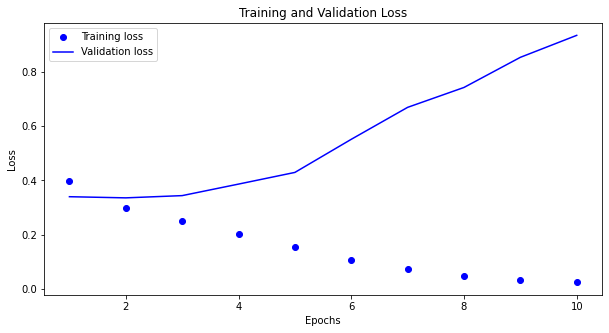

In [78]:
import matplotlib.pyplot as plt

# history 객체에서 loss와 val_loss 값을 가져옴
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ㅋㅋㅋㅋ2epoch부터 과적합이다....

In [79]:
# RNN 모델 구성하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# 하이퍼파라미터
vocab_size = len(word_index_bpe)
embedding_dim = 128
max_length = 71

# 모델 구성
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 128)           1024000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 71, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,164,097
Trainable params: 1,164,097
Non-trainable params: 0
_________________________________________________________________


In [80]:
history = model.fit(
    tensor_bpe_t, y_train,
    epochs=2,
    validation_data=(tensor_bpe_v, y_val),
    batch_size=32
)


Epoch 1/2
2868/2868 [==============================] - 46s 15ms/step - loss: 0.3954 - accuracy: 0.8174 - val_loss: 0.3373 - val_accuracy: 0.8519
Epoch 2/2
2868/2868 [==============================] - 41s 14ms/step - loss: 0.2969 - accuracy: 0.8712 - val_loss: 0.3382 - val_accuracy: 0.8504


In [81]:
# 평가하기

test_text = test_data['document']
test_label = test_data['label']

tensor_bpe_test, word_index_test, index_word_test = sp_tokenize_bpe(s_bpe, test_text)
label_test = tf.convert_to_tensor(test_label)

In [83]:
results_rnn = model.evaluate(tensor_bpe_test,label_test, verbose=2)
print(results_rnn)


1200/1200 - 6s - loss: 0.3492 - accuracy: 0.8436
[0.34918010234832764, 0.84361732006073]


## Unigram

In [84]:
tensor_uni_t, word_index_uni_t, index_word_uni_t = sp_tokenize_uni(s_uni, X_train)
tensor_uni_v, word_index_uni_v, index_word_uni_v = sp_tokenize_uni(s_uni, X_val)
tensor_uni, word_index_uni, index_word_uni = sp_tokenize_uni(s_uni, train_text)

In [85]:
# RNN 모델 구성하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# 하이퍼파라미터
vocab_size = len(word_index_uni)
embedding_dim = 128
max_length = 71

# 모델 구성
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 71, 128)           1024000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 71, 128)           98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,164,097
Trainable params: 1,164,097
Non-trainable params: 0
_________________________________________________________________


In [86]:
# 모델 학습

history = model.fit(
    tensor_uni_t, y_train,
    epochs=10,
    validation_data=(tensor_uni_v, y_val),
    batch_size=32
)

Epoch 1/10
2868/2868 [==============================] - 46s 15ms/step - loss: 0.3950 - accuracy: 0.8167 - val_loss: 0.3355 - val_accuracy: 0.8522
Epoch 2/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.2992 - accuracy: 0.8701 - val_loss: 0.3333 - val_accuracy: 0.8524
Epoch 3/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.2504 - accuracy: 0.8930 - val_loss: 0.3562 - val_accuracy: 0.8498
Epoch 4/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.2012 - accuracy: 0.9167 - val_loss: 0.3714 - val_accuracy: 0.8492
Epoch 5/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.1504 - accuracy: 0.9416 - val_loss: 0.4558 - val_accuracy: 0.8400
Epoch 6/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.1037 - accuracy: 0.9608 - val_loss: 0.5153 - val_accuracy: 0.8395
Epoch 7/10
2868/2868 [==============================] - 41s 14ms/step - loss: 0.0695 - accuracy: 0.9745 - val_loss: 0.6465 -

In [87]:
#역시나 과적합,,,,,
# RNN 모델 구성하기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# 하이퍼파라미터
vocab_size = len(word_index_uni)
embedding_dim = 128
max_length = 71

# 모델 구성
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 71, 128)           1024000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 71, 128)           98816     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,164,097
Trainable params: 1,164,097
Non-trainable params: 0
_________________________________________________________________


In [88]:
history = model.fit(
    tensor_uni_t, y_train,
    epochs=2,
    validation_data=(tensor_uni_v, y_val),
    batch_size=32
)


Epoch 1/2
2868/2868 [==============================] - 46s 15ms/step - loss: 0.3987 - accuracy: 0.8159 - val_loss: 0.3399 - val_accuracy: 0.8496
Epoch 2/2
2868/2868 [==============================] - 41s 14ms/step - loss: 0.2993 - accuracy: 0.8712 - val_loss: 0.3312 - val_accuracy: 0.8552


In [89]:
# 평가하기

test_text = test_data['document']
test_label = test_data['label']

tensor_uni_test, word_index_test, index_word_test = sp_tokenize_uni(s_uni, test_text)
label_test = tf.convert_to_tensor(test_label)

results_rnn = model.evaluate(tensor_uni_test,label_test, verbose=2)
print(results_rnn)

1200/1200 - 6s - loss: 0.3415 - accuracy: 0.8466
[0.34145259857177734, 0.8466387391090393]


## 회고

1. 에폭수가 적어서인지 모델 학습이 제대로 이루어지지 않은 것 같다. 
2. 모델 층을 한층 더 늘릴걸 (dense층?) 그랬나...? 싶다.... 시간이 촉박해서 다 못해서 아쉬웠다. 
3. 전체적인 성능은 unigram이 쬐끔 더 나은데 한국어처럼 어취의 변화가 많은 언어에서는 드물게 등장하는 서브워드를 효과적으로 처리 못했을 수 있다. 